<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

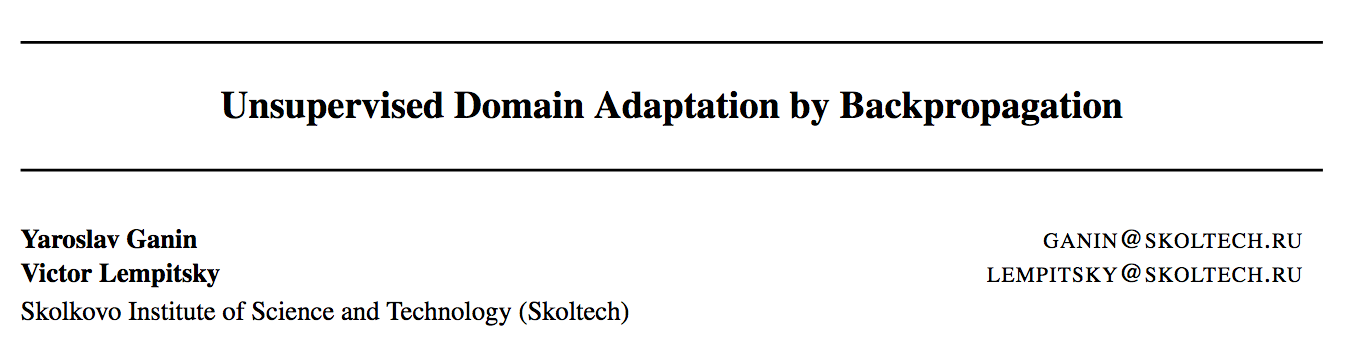

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [ ]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2024-12-24 11:40:38--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.85K  --.-KB/s    in 0s      

2024-12-24 11:40:38 (61.8 MB/s) - ‘mnistm.py’ saved [2918/2918]



In [ ]:
from mnistm import create_mnistm
create_mnistm()


Creating MNIST-M... That may takes a minute
Loading BSR training images
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.82MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [ ]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

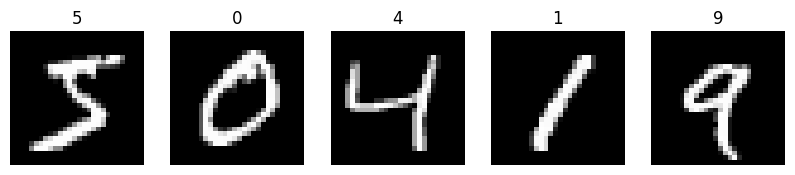

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [ ]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

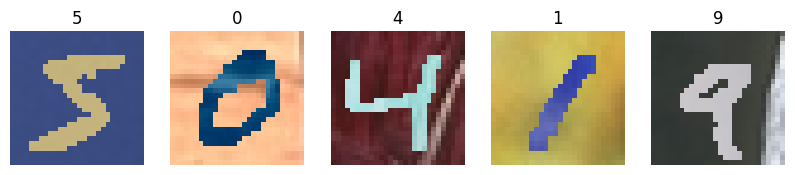

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

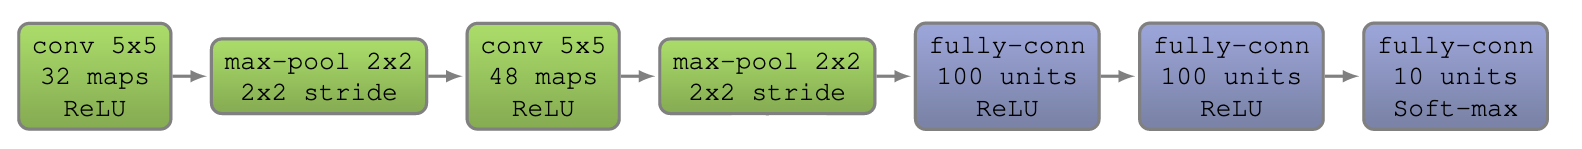

In [ ]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),  # Assuming grayscale input
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )

    self.classif = nn.Sequential(
        nn.Linear(in_features=48 * 4 * 4, out_features=100),  # Adjust 4x4 based on input dimensions
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=10),  # 10 output classes
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    features = self.cnn(x)
    features = features.view(features.size(0), -1)  # Flatten

    x = self.classif(features)

    return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [ ]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [ ]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 2.0141
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 1.67781
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 1.59911
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 1.58865
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 1.58389
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 1.58108
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 1.57898
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 1.5774
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 1.57615
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 1.57516
	Learning rate = 0.0016556002607617019
Test loss: 1.57351, test acc: 88.7


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.9697, test acc: 49.08


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

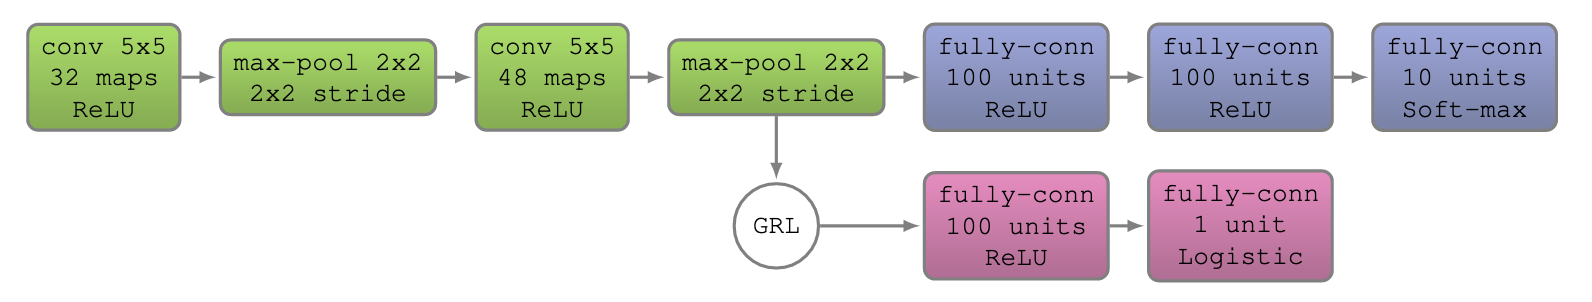

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [ ]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = grad * factor

    return reversed_grad, None

In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

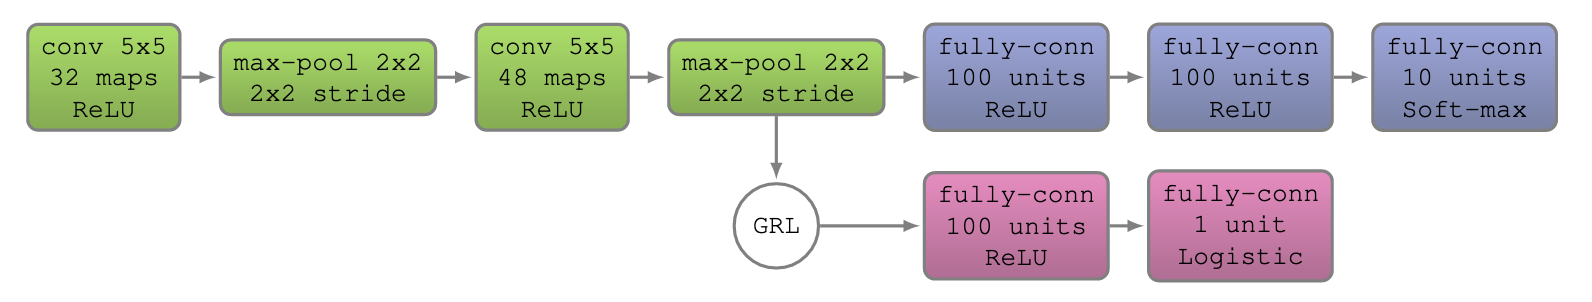

In [ ]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),  # Assuming grayscale input
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )

    self.classif = nn.Sequential(
        nn.Linear(in_features=48 * 4 * 4, out_features=100),  # Adjust 4x4 based on input dimensions
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=10),  # 10 output classes
        nn.Softmax(dim=1)
    )

    self.domain = nn.Sequential(
        nn.Linear(in_features=48 * 4 * 4, out_features=100),  # Match with CNN output
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=1),
        nn.Sigmoid()
    )

  def forward(self, x, factor=1):
    # Feature extraction
    features = self.cnn(x)
    features = features.view(features.size(0), -1)  # Flatten

    # Gradient reversal layer
    reversed_features = GradientReversal.apply(features, factor)

    # Predictions
    class_pred = self.classif(features)
    domain_pred = self.domain(reversed_features)

    return class_pred, domain_pred


In [ ]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [ ]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

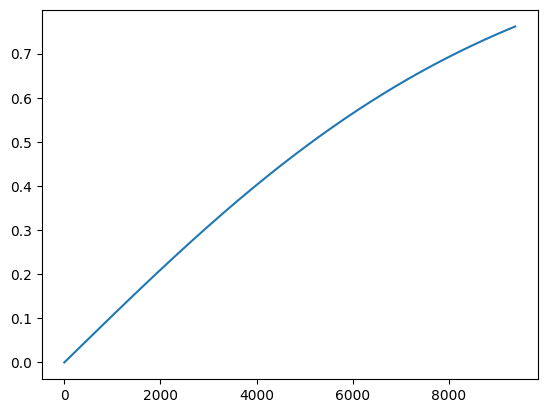

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [ ]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = torch.nn.functional.cross_entropy(cls_logits[:len(xs)], ys)

    domain_labels = torch.cat((
      torch.zeros(xs.size(0)),  # Source domain label 0
      torch.ones(xt.size(0))   # Target domain label 1
    )).cuda()

    bce = torch.nn.functional.binary_cross_entropy_with_logits(domain_logits.squeeze(), domain_labels)
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 1.82441, domain loss: 0.2723
GRL factor 0.049958374957880025
Epoch 1, class loss: 1.51694, domain loss: 0.25866
GRL factor 0.0996679946249559
Epoch 2, class loss: 1.49045, domain loss: 0.25691
GRL factor 0.14888503362331806
Epoch 3, class loss: 1.48347, domain loss: 0.25584
GRL factor 0.197375320224904
Epoch 4, class loss: 1.47957, domain loss: 0.25508
GRL factor 0.2449186624037092
Epoch 5, class loss: 1.4775, domain loss: 0.25471
GRL factor 0.2913126124515908
Epoch 6, class loss: 1.47618, domain loss: 0.2543
GRL factor 0.3363755443363323
Epoch 7, class loss: 1.47446, domain loss: 0.25369
GRL factor 0.379948962255225
Epoch 8, class loss: 1.47346, domain loss: 0.25343
GRL factor 0.4218990052500078
Epoch 9, class loss: 1.47267, domain loss: 0.25316
GRL factor 0.4621171572600098
Epoch 10, class loss: 1.4719, domain loss: 0.25296
GRL factor 0.5005202111902354
Epoch 11, class loss: 1.47133, domain loss: 0.25274
GRL factor 0.5370495669980351
Epoch 12, clas

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [ ]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

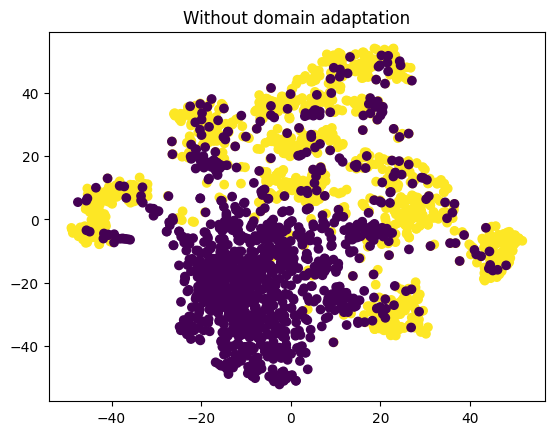

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

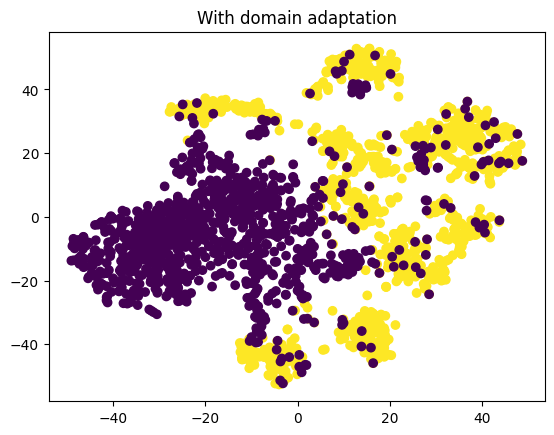

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

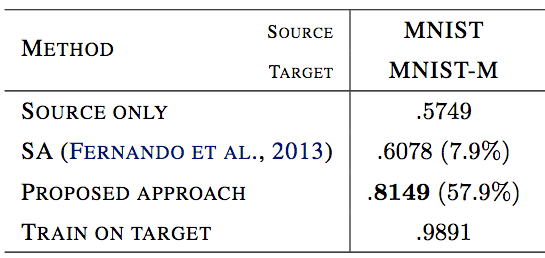

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

In [ ]:
epochs = 40

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = torch.nn.functional.cross_entropy(cls_logits[:len(xs)], ys)

    domain_labels = torch.cat((
      torch.zeros(xs.size(0)),  # Source domain label 0
      torch.ones(xt.size(0))   # Target domain label 1
    )).cuda()

    bce = torch.nn.functional.binary_cross_entropy_with_logits(domain_logits.squeeze(), domain_labels)
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 1.78008, domain loss: 0.26862
GRL factor 0.024994792968420665
Epoch 1, class loss: 1.58394, domain loss: 0.25774
GRL factor 0.049958374957880025
Epoch 2, class loss: 1.5738, domain loss: 0.25628
GRL factor 0.0748596906874992
Epoch 3, class loss: 1.56715, domain loss: 0.25523
GRL factor 0.0996679946249559
Epoch 4, class loss: 1.5644, domain loss: 0.25449
GRL factor 0.12435300177159614
Epoch 5, class loss: 1.56232, domain loss: 0.25397
GRL factor 0.14888503362331806
Epoch 6, class loss: 1.56052, domain loss: 0.25354
GRL factor 0.17323515783466026
Epoch 7, class loss: 1.55925, domain loss: 0.25335
GRL factor 0.197375320224904
Epoch 8, class loss: 1.55795, domain loss: 0.25307
GRL factor 0.22127846789844408
Epoch 9, class loss: 1.55682, domain loss: 0.25294
GRL factor 0.2449186624037092
Epoch 10, class loss: 1.55599, domain loss: 0.25276
GRL factor 0.2682711820216015
Epoch 11, class loss: 1.55525, domain loss: 0.25267
GRL factor 0.2913126124515908
Epoch 